#### Imports, functions and classes

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.datasets import make_classification

# -----------------------------
#  Models
# -----------------------------

'''standard clustering'''
class Clust(nn.Module):
    def __init__(self, n, c, m, temperature):
        super(Clust, self).__init__()
        self.A1 = nn.Parameter(torch.rand(n, c, requires_grad=True))
        self.A2 = nn.Parameter(torch.rand(c, m, requires_grad=True))
        self.temperature = temperature

    def temperature_scaled_softmax(self, logits):
        scaled_logits = logits / self.temperature
        return F.softmax(scaled_logits, dim=1)

    def forward(self):
        self.A_1_softmaxed = self.temperature_scaled_softmax(self.A1)
        res = torch.matmul(self.A_1_softmaxed, self.A2)  # prox_plus
        return res

    def get_memberships(self):
        """
        Return the n x c soft cluster assignment matrix.
        Each row is a probability distribution over clusters.
        """
        return self.A_1_softmaxed

'''Khatri-Rao clustering'''
class KRClust(nn.Module):  
    def __init__(self, n, c, m, temperature, operator="product"):
        super(KRClust, self).__init__()
        self.A1 = nn.Parameter(torch.rand(n, c, requires_grad=True))
        self.A2 = nn.Parameter(torch.rand(c, m, requires_grad=True))
        self.B1 = nn.Parameter(torch.rand(n, c, requires_grad=True))
        self.B2 = nn.Parameter(torch.rand(c, m, requires_grad=True))
        self.temperature = temperature
        self.operator = operator

    def temperature_scaled_softmax(self, logits):
        """
        Generic temperature-scaled softmax:
        logits: (n, K) -> (n, K), rows sum to 1.
        """
        scaled_logits = logits / self.temperature
        return F.softmax(scaled_logits, dim=1)

    def forward(self):
        """
        Build a single (n x c^2) soft assignment matrix as in Clust:
        - first create combined logits over all (p, q) pairs
        - then apply temperature_scaled_softmax ONCE over the c^2 dimension
        """
        n, c = self.A1.shape
        m = self.A2.shape[1]

        # Pairwise logits over proto-indices: (n, c, c)
        # (p, q) logits = A1[i, p] + B1[i, q]
        pairwise_logits = self.A1.unsqueeze(2) + self.B1.unsqueeze(1)

        # Flatten to (n, c^2)
        combined_logits = pairwise_logits.view(n, c * c)

        # This is the analogue of Clust: softmax over the K = c^2 clusters
        self.combined_memberships = self.temperature_scaled_softmax(combined_logits)  # (n, c^2)

        # For interpretability / inertia: marginals as proto-memberships
        pairwise_probs = self.combined_memberships.view(n, c, c)   # (n, c, c)
        self.A_1_softmaxed = pairwise_probs.sum(dim=2)             # (n, c)
        self.B_1_softmaxed = pairwise_probs.sum(dim=1)             # (n, c)

        # ----- Combined centroids -----
        # A2, B2: (c, m)
        if self.operator == "product":
            C = self.A2.unsqueeze(1) * self.B2.unsqueeze(0)  # (c, c, m)
        else:  # "sum"
            C = self.A2.unsqueeze(1) + self.B2.unsqueeze(0)  # (c, c, m)

        # Flatten centroids to (c^2, m)
        centroids = C.view(c * c, m)

        # Single matrix product: (n, c^2) @ (c^2, m) -> (n, m)
        self.centroids = centroids
        return self.combined_memberships @ centroids

    def get_memberships(self):
        """
        Return the n x (c^2) soft cluster assignment matrix.
        Each row is a probability distribution over the c^2 combined clusters.
        Flattening uses (p, q) -> p * c + q.
        """
        return self.combined_memberships





# -----------------------------
#  Hard inertia from assignments
# -----------------------------
def hard_inertia_from_model(model: nn.Module, D: torch.Tensor) -> float:
    """
    Compute hard k-means-style inertia from a trained Clust or KRClust model.

    Steps:
    1. Call model() to ensure memberships / centroids are up to date.
    2. Get soft memberships from model.get_memberships().
    3. Argmax over clusters -> hard assignments.
    4. Use the centroids matrix (second matrix) to compute:
           sum_i || D[i] - centroid_{z_i} ||^2
    """
    model.eval()
    with torch.no_grad():
        # Forward once to refresh internal buffers (memberships, centroids)
        _ = model()

        # 1) Soft memberships
        memberships = model.get_memberships()   # (n, K) where K = c or c^2

        # 2) Hard assignments
        cluster_ids = memberships.argmax(dim=1)  # (n,)

        # 3) Centroids
        if isinstance(model, Clust):
            centroids = model.A2               # (c, m)
        elif isinstance(model, KRClust):
            centroids = model.centroids        # (c^2, m)
        else:
            raise ValueError("Unknown model type for inertia computation.")

        # 4) Gather assigned centroids for each point
        assigned_centroids = centroids[cluster_ids]  # (n, m)

        # 5) Inertia = sum of squared distances
        sq_dists = ((D - assigned_centroids) ** 2).sum(dim=1)  # (n,)
        inertia = sq_dists.sum().item()

    return inertia

 


def generate_classification():
    '''
    Generate Classification dataset

  
    Returns
    -------
    X : np.ndarray (data) 
    L : np.ndarray (labels) 
    '''

    X, L = make_classification(
        n_samples=5000,
        n_features=10,
        n_informative=10,
        n_redundant=0,
        n_repeated=0,
        n_classes=100,
        n_clusters_per_class=1,
        random_state=42
    )
    return X, L


@torch.no_grad()
def init_clust_A2_uniform_like_data(model, D: torch.Tensor, per_feature: bool = True):
    """
    Initialize Clust.A2 uniformly in the data range of D.
    """
    if per_feature:
        lo = D.min(dim=0).values
        hi = D.max(dim=0).values
        hi = torch.where(hi > lo, hi, lo + 1e-12)
        U = torch.rand_like(model.A2)
        model.A2.copy_(lo.unsqueeze(0) + U * (hi - lo).unsqueeze(0))
    else:
        lo = float(D.min())
        hi = float(D.max())
        if hi <= lo: hi = lo + 1e-12
        model.A2.uniform_(lo, hi)


@torch.no_grad()
def init_kr_semicentroids_so_full_centroids_match_data_range(
    model, D: torch.Tensor, per_feature: bool = True, eps: float = 1e-8
):
    """
    KRClust: initialize A2 and B2 so that the implied full centroids
      C[p,q] = A2[p] (+ or *) B2[q]
    lie in the same range as D (feature-wise by default), while *exactly*
    preserving the identity C = combine(A2,B2).

    - operator == "sum": uses affine rescaling on A2 and B2 (split shift equally)
    - operator == "product": uses log-space affine rescaling (split equally),
      requiring strictly positive ranges (uses eps for stability)
    """
    if not hasattr(model, "A2") or not hasattr(model, "B2"):
        raise ValueError("This initializer is for KRClust-like models with A2 and B2.")

    c, m = model.A2.shape

    if per_feature:
        dlo = D.min(dim=0).values  # (m,)
        dhi = D.max(dim=0).values  # (m,)
    else:
        dlo = D.min().repeat(m)
        dhi = D.max().repeat(m)

    # avoid degenerate / invalid intervals
    dhi = torch.where(dhi > dlo, dhi, dlo + 1e-12)

    if model.operator == "sum":
        # 1) random semicentroids (any distribution is fine; we'll rescale)
        model.A2.uniform_(0.0, 1.0)
        model.B2.uniform_(0.0, 1.0)

        # 2) implied full centroids
        C = model.A2.unsqueeze(1) + model.B2.unsqueeze(0)  # (c,c,m)

        # 3) feature-wise affine map: C' = s*C + t -> [dlo, dhi]
        cmin = C.amin(dim=(0, 1))  # (m,)
        cmax = C.amax(dim=(0, 1))  # (m,)
        cmax = torch.where(cmax > cmin, cmax, cmin + 1e-12)

        s = (dhi - dlo) / (cmax - cmin)          # (m,)
        t = dlo - s * cmin                        # (m,)

        # 4) split the transform across A2 and B2 so that (A2'+B2') == C'
        #    If A2' = s*A2 + t/2 and B2' = s*B2 + t/2, then A2'+B2' = s*(A2+B2)+t
        model.A2.mul_(s.unsqueeze(0)).add_(0.5 * t.unsqueeze(0))
        model.B2.mul_(s.unsqueeze(0)).add_(0.5 * t.unsqueeze(0))

    elif model.operator == "product":
        # Product needs positivity; use eps floor for the target range too.
        dlo_pos = torch.clamp(dlo, min=eps)
        dhi_pos = torch.clamp(dhi, min=dlo_pos + eps)

        # 1) random semicentroids in (0,1) then shift to (eps, 1+eps)
        model.A2.uniform_(0.0, 1.0)
        model.B2.uniform_(0.0, 1.0)
        model.A2.add_(eps)
        model.B2.add_(eps)

        # 2) log-space implied full centroids: logC = logA + logB
        logA = torch.log(model.A2)
        logB = torch.log(model.B2)
        logC = logA.unsqueeze(1) + logB.unsqueeze(0)  # (c,c,m)

        # 3) feature-wise affine map in log-space: logC' = s*logC + t
        cmin = logC.amin(dim=(0, 1))
        cmax = logC.amax(dim=(0, 1))
        cmax = torch.where(cmax > cmin, cmax, cmin + 1e-12)

        target_min = torch.log(dlo_pos)
        target_max = torch.log(dhi_pos)

        s = (target_max - target_min) / (cmax - cmin)
        t = target_min - s * cmin

        # 4) split evenly: logA' = s*logA + t/2, logB' = s*logB + t/2
        logA = logA.mul(s.unsqueeze(0)).add(0.5 * t.unsqueeze(0))
        logB = logB.mul(s.unsqueeze(0)).add(0.5 * t.unsqueeze(0))

        model.A2.copy_(torch.exp(logA))
        model.B2.copy_(torch.exp(logB))

    else:
        raise ValueError(f"Unknown KRClust operator: {model.operator}")



def soft_kmeans_loss(D: torch.Tensor, P: torch.Tensor, M: torch.Tensor) -> torch.Tensor:
    """
    D: (n, m) data
    P: (n, K) soft assignments, rows sum to 1
    M: (K, m) centroids

    returns scalar: sum_{i,k} P_ik * ||D_i - M_k||^2
    """
    # (n, 1)
    D_norm2 = (D * D).sum(dim=1, keepdim=True)
    # (1, K)
    M_norm2 = (M * M).sum(dim=1, keepdim=True).T
    # (n, K)
    dot = D @ M.T
    dist2 = D_norm2 + M_norm2 - 2.0 * dot
    return (P * dist2).sum()


def train_soft_kmeans_with_temperature_lr(
    model: nn.Module,
    D: torch.Tensor,
    epochs: int = 5000,
    lr_start: float = 1e-1,   # 0.1
    lr_end: float = 1e-3,     # 0.001
    start_temp: float = None,
    end_temp: float = None,
    print_every: int = 500,
):
    model.train()

    if start_temp is None:
        start_temp = float(model.temperature)
    if end_temp is None:
        end_temp = start_temp

    optimizer = optim.Adam(model.parameters(), lr=lr_start)

    for epoch in range(1, epochs + 1):
        # ---- shared linear schedule factor ----
        alpha = (epoch - 1) / max(epochs - 1, 1)

        # ---- temperature annealing ----
        model.temperature = (1 - alpha) * start_temp + alpha * end_temp

        # ---- LR annealing ----
        lr = (1 - alpha) * lr_start + alpha * lr_end
        for pg in optimizer.param_groups:
            pg["lr"] = lr

        optimizer.zero_grad()

        # Forward to refresh memberships/centroids buffers
        _ = model()

        # Fetch memberships + centroids
        P = model.get_memberships()  # (n, K)

        if isinstance(model, Clust):
            M = model.A2             # (K, m) where K=c
        elif isinstance(model, KRClust):
            M = model.centroids      # (K, m) where K=c^2
        else:
            raise ValueError("Unknown model type.")

        loss = soft_kmeans_loss(D, P, M)
        loss.backward()
        optimizer.step()

        if epoch % print_every == 0:
            print(
                f"[{epoch}/{epochs}] "
                f"SoftKMeansLoss={loss.item():.6f} "
                f"Temp={model.temperature:.4f} "
                f"LR={lr:.6f}"
            )

    return model




#### Generate Data 

In [ ]:
X,L = generate_classification()
n, m = X.shape
D = torch.tensor(X, dtype=torch.float32)

#### Run experiment


==== (k1,k2)=(10,10) | run 1/3 ====
[500/5000] SoftKMeansLoss=157696.234375 Temp=0.9102 LR=0.090517
[1000/5000] SoftKMeansLoss=156269.093750 Temp=0.8201 LR=0.081015
[1500/5000] SoftKMeansLoss=155795.281250 Temp=0.7301 LR=0.071513
[2000/5000] SoftKMeansLoss=155624.625000 Temp=0.6401 LR=0.062011
[2500/5000] SoftKMeansLoss=155556.125000 Temp=0.5501 LR=0.052510
[3000/5000] SoftKMeansLoss=155512.421875 Temp=0.4601 LR=0.043008
[3500/5000] SoftKMeansLoss=155498.265625 Temp=0.3701 LR=0.033506
[4000/5000] SoftKMeansLoss=155496.703125 Temp=0.2800 LR=0.024004
[4500/5000] SoftKMeansLoss=155496.703125 Temp=0.1900 LR=0.014502
[5000/5000] SoftKMeansLoss=155496.703125 Temp=0.1000 LR=0.005000
Clust inertia: 155496.71875
[500/5000] SoftKMeansLoss=118549.601562 Temp=0.9102 LR=0.090517
[1000/5000] SoftKMeansLoss=117939.492188 Temp=0.8201 LR=0.081015
[1500/5000] SoftKMeansLoss=117677.093750 Temp=0.7301 LR=0.071513
[2000/5000] SoftKMeansLoss=117577.031250 Temp=0.6401 LR=0.062011
[2500/5000] SoftKMeansLoss=

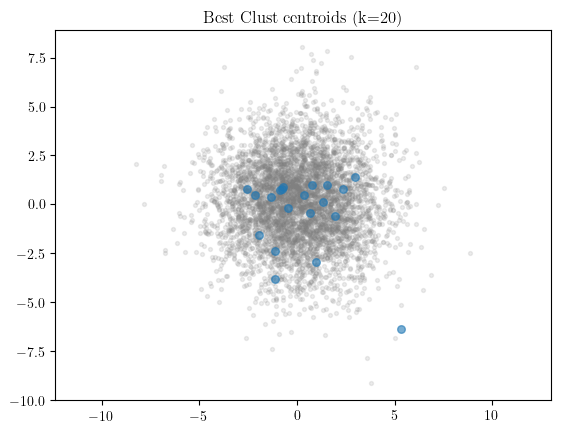


==== (k1,k2)=(15,15) | run 1/3 ====
[500/5000] SoftKMeansLoss=143319.718750 Temp=0.9102 LR=0.090517
[1000/5000] SoftKMeansLoss=142204.062500 Temp=0.8201 LR=0.081015
[1500/5000] SoftKMeansLoss=141915.578125 Temp=0.7301 LR=0.071513
[2000/5000] SoftKMeansLoss=141819.921875 Temp=0.6401 LR=0.062011
[2500/5000] SoftKMeansLoss=141764.437500 Temp=0.5501 LR=0.052510
[3000/5000] SoftKMeansLoss=141736.921875 Temp=0.4601 LR=0.043008
[3500/5000] SoftKMeansLoss=141736.218750 Temp=0.3701 LR=0.033506
[4000/5000] SoftKMeansLoss=141736.234375 Temp=0.2800 LR=0.024004
[4500/5000] SoftKMeansLoss=141736.234375 Temp=0.1900 LR=0.014502
[5000/5000] SoftKMeansLoss=141736.234375 Temp=0.1000 LR=0.005000
Clust inertia: 141736.21875
[500/5000] SoftKMeansLoss=102351.695312 Temp=0.9102 LR=0.090517
[1000/5000] SoftKMeansLoss=101877.531250 Temp=0.8201 LR=0.081015
[1500/5000] SoftKMeansLoss=101696.296875 Temp=0.7301 LR=0.071513
[2000/5000] SoftKMeansLoss=101593.523438 Temp=0.6401 LR=0.062011
[2500/5000] SoftKMeansLoss=

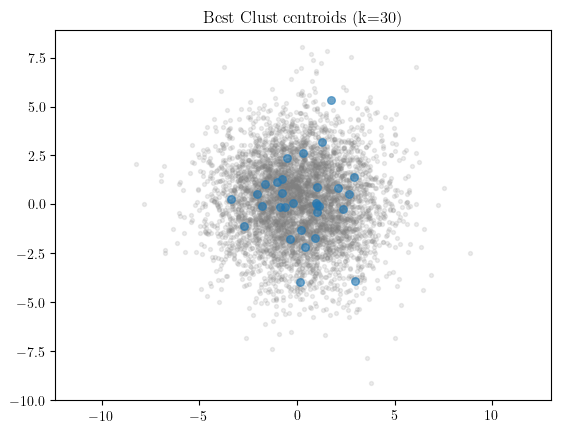


==== (k1,k2)=(20,20) | run 1/3 ====
[500/5000] SoftKMeansLoss=136531.406250 Temp=0.9102 LR=0.090517
[1000/5000] SoftKMeansLoss=135844.406250 Temp=0.8201 LR=0.081015
[1500/5000] SoftKMeansLoss=135581.125000 Temp=0.7301 LR=0.071513
[2000/5000] SoftKMeansLoss=135461.468750 Temp=0.6401 LR=0.062011
[2500/5000] SoftKMeansLoss=135456.109375 Temp=0.5501 LR=0.052510
[3000/5000] SoftKMeansLoss=135439.000000 Temp=0.4601 LR=0.043008
[3500/5000] SoftKMeansLoss=135430.125000 Temp=0.3701 LR=0.033506
[4000/5000] SoftKMeansLoss=135427.937500 Temp=0.2800 LR=0.024004
[4500/5000] SoftKMeansLoss=135427.937500 Temp=0.1900 LR=0.014502
[5000/5000] SoftKMeansLoss=135427.937500 Temp=0.1000 LR=0.005000
Clust inertia: 135427.96875
[500/5000] SoftKMeansLoss=92533.054688 Temp=0.9102 LR=0.090517
[1000/5000] SoftKMeansLoss=92016.992188 Temp=0.8201 LR=0.081015
[1500/5000] SoftKMeansLoss=91835.265625 Temp=0.7301 LR=0.071513
[2000/5000] SoftKMeansLoss=91736.484375 Temp=0.6401 LR=0.062011
[2500/5000] SoftKMeansLoss=9172

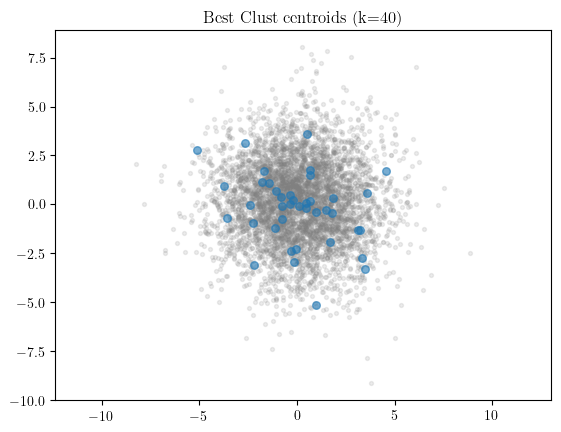


==== (k1,k2)=(25,25) | run 1/3 ====
[500/5000] SoftKMeansLoss=126234.367188 Temp=0.9102 LR=0.090517
[1000/5000] SoftKMeansLoss=125484.640625 Temp=0.8201 LR=0.081015
[1500/5000] SoftKMeansLoss=125226.390625 Temp=0.7301 LR=0.071513
[2000/5000] SoftKMeansLoss=125128.929688 Temp=0.6401 LR=0.062011
[2500/5000] SoftKMeansLoss=125080.312500 Temp=0.5501 LR=0.052510
[3000/5000] SoftKMeansLoss=125076.859375 Temp=0.4601 LR=0.043008
[3500/5000] SoftKMeansLoss=125070.609375 Temp=0.3701 LR=0.033506
[4000/5000] SoftKMeansLoss=125070.601562 Temp=0.2800 LR=0.024004
[4500/5000] SoftKMeansLoss=125070.601562 Temp=0.1900 LR=0.014502
[5000/5000] SoftKMeansLoss=125070.601562 Temp=0.1000 LR=0.005000
Clust inertia: 125070.59375
[500/5000] SoftKMeansLoss=87300.164062 Temp=0.9102 LR=0.090517
[1000/5000] SoftKMeansLoss=86688.101562 Temp=0.8201 LR=0.081015
[1500/5000] SoftKMeansLoss=86465.656250 Temp=0.7301 LR=0.071513
[2000/5000] SoftKMeansLoss=86396.789062 Temp=0.6401 LR=0.062011
[2500/5000] SoftKMeansLoss=8636

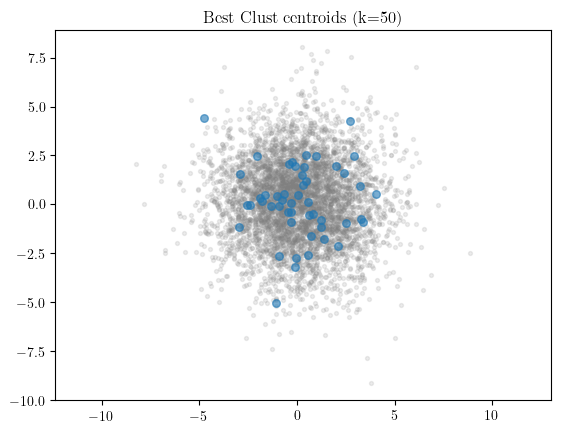


==== (k1,k2)=(30,30) | run 1/3 ====
[500/5000] SoftKMeansLoss=124151.992188 Temp=0.9102 LR=0.090517
[1000/5000] SoftKMeansLoss=123189.242188 Temp=0.8201 LR=0.081015
[1500/5000] SoftKMeansLoss=122901.875000 Temp=0.7301 LR=0.071513
[2000/5000] SoftKMeansLoss=122758.179688 Temp=0.6401 LR=0.062011
[2500/5000] SoftKMeansLoss=122701.640625 Temp=0.5501 LR=0.052510
[3000/5000] SoftKMeansLoss=122696.289062 Temp=0.4601 LR=0.043008
[3500/5000] SoftKMeansLoss=122694.921875 Temp=0.3701 LR=0.033506
[4000/5000] SoftKMeansLoss=122694.031250 Temp=0.2800 LR=0.024004
[4500/5000] SoftKMeansLoss=122694.023438 Temp=0.1900 LR=0.014502
[5000/5000] SoftKMeansLoss=122694.023438 Temp=0.1000 LR=0.005000
Clust inertia: 122694.03125
[500/5000] SoftKMeansLoss=81863.578125 Temp=0.9102 LR=0.090517
[1000/5000] SoftKMeansLoss=81113.945312 Temp=0.8201 LR=0.081015
[1500/5000] SoftKMeansLoss=80858.023438 Temp=0.7301 LR=0.071513
[2000/5000] SoftKMeansLoss=80779.101562 Temp=0.6401 LR=0.062011
[2500/5000] SoftKMeansLoss=8072

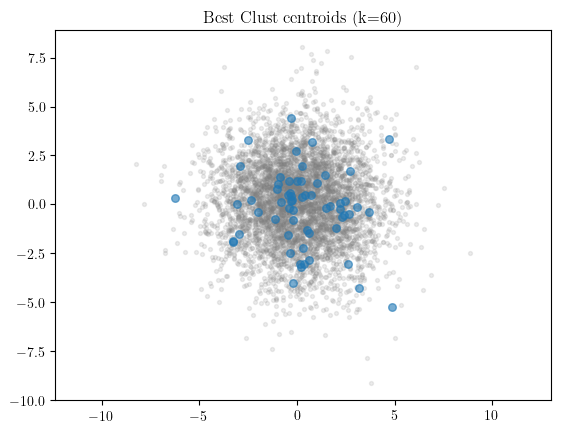

In [ ]:
import copy
import matplotlib.pyplot as plt

N = 3  # number of restarts

all_ours_inertias = []      # KRClust (sum)
all_ours2_inertias = []     # KRClust (product)
all_inertias_bs = []        # Clust baseline

for (k1, k2) in [(10,10), (15,15), (20,20), (25,25), (30,30)]:

    c = k1
    c_bs = k1 + k2

    best_clust_inertia = float("inf")
    best_kr_inertia = float("inf")
    best_kh2_inertia = float("inf")

    best_clust = None
    best_kr = None
    best_kh2 = None

    for run in range(N):
        print(f"\n==== (k1,k2)=({k1},{k2}) | run {run+1}/{N} ====")

        # -------- Clust --------
        clust = Clust(n, c_bs, m, temperature=1.0)
        init_clust_A2_uniform_like_data(clust, D, per_feature=True)

        train_soft_kmeans_with_temperature_lr(
            clust, D,
            epochs=5000,
            lr_start=1e-1, lr_end=5e-3,
            start_temp=1, end_temp=0.1,
            print_every=500,
        )

        clust_inertia = hard_inertia_from_model(clust, D)
        print("Clust inertia:", clust_inertia)

        if clust_inertia < best_clust_inertia:
            best_clust_inertia = clust_inertia
            best_clust = copy.deepcopy(clust)

        # -------- KRClust (sum) --------
        krclust = KRClust(n, c, m, temperature=1.0, operator="sum")
        init_kr_semicentroids_so_full_centroids_match_data_range(
            krclust, D, per_feature=True
        )

        train_soft_kmeans_with_temperature_lr(
            krclust, D,
            epochs=5000,
            lr_start=1e-1, lr_end=5e-3,
            start_temp=1, end_temp=0.1,
            print_every=500,
        )

        kr_inertia = hard_inertia_from_model(krclust, D)
        print("KRClust (sum) inertia:", kr_inertia)

        if kr_inertia < best_kr_inertia:
            best_kr_inertia = kr_inertia
            best_kr = copy.deepcopy(krclust)

        # -------- KRClust (product) --------
        krclust2 = KRClust(n, c, m, temperature=1.0, operator="product")
        init_kr_semicentroids_so_full_centroids_match_data_range(
            krclust2, D, per_feature=True
        )

        train_soft_kmeans_with_temperature_lr(
            krclust2, D,
            epochs=5000,
            lr_start=1e-1, lr_end=5e-3,
            start_temp=1, end_temp=0.1,
            print_every=500,
        )

        kh2_inertia = hard_inertia_from_model(krclust2, D)
        print("KRClust (product) inertia:", kh2_inertia)

        if kh2_inertia < best_kh2_inertia:
            best_kh2_inertia = kh2_inertia
            best_kh2 = copy.deepcopy(krclust2)

    # ---- store best-of-N inertias ----
    all_inertias_bs.append(best_clust_inertia)
    all_ours_inertias.append(best_kr_inertia)
    all_ours2_inertias.append(best_kh2_inertia)

    print("\n==== BEST over 3 runs ====")
    print("Clust            :", best_clust_inertia)
    print("KRClust (sum)    :", best_kr_inertia)
    print("KRClust (product):", best_kh2_inertia)

    # ---- plot best centroids for standard clustering ----
    A2 = best_clust.A2.detach().cpu().numpy()
    plt.scatter(X[:, 0], X[:, 1], s=8, alpha=0.15, color="gray")
    plt.scatter(A2[:, 0], A2[:, 1], s=30, marker="o", alpha=0.6)
    plt.title(f"Best Clust centroids (k={c_bs})")
    plt.axis("equal")
    plt.show()
